# Challenges ENS prédiction du prix de l'électricité

## Auteur: Paul COFFI / Fleurine Keza

L'objectif de ce projet est de prédire le  prix de l'électricité en fonction des variables:

## Traitement des données

In [6]:
import pandas as pd 
import numpy as np

X= pd.read_csv("C:/Users/ccppm/OneDrive/Documents/ChallengeENSelectricité/X_train_Wwou3IE.csv")
y= pd.read_csv("C:/Users/ccppm/OneDrive/Documents/ChallengeENSelectricité/y_train_jJtXgMX.csv")

X['DELIVERY_START'] = pd.to_datetime(X['DELIVERY_START'], utc= True)
X['year'] = X['DELIVERY_START'].dt.year
X['month'] = X['DELIVERY_START'].dt.month
X['day'] = X['DELIVERY_START'].dt.day
X['hour'] = X['DELIVERY_START'].dt.hour
X['weekday'] = X['DELIVERY_START'].dt.weekday  # Lundi = 0, Dimanche = 6
X= X.drop(columns=['DELIVERY_START'])
y= y.drop(columns=['DELIVERY_START'])


**Nombre de valeurs manquantes pour chaque variable**

In [10]:
n_missing_values= X.isnull().sum()/len(X)
n_missing_values= n_missing_values.to_frame()
n_missing_values
n_missing_values.columns= ['Données manquantes en pct'
                          ]
n_missing_values

,Données manquantes en pct
load_forecast,0.121358
coal_power_available,0.000094
gas_power_available,0.000094
nucelear_power_available,0.000094
wind_power_forecasts_average,0.002263
solar_power_forecasts_average,0.002263
wind_power_forecasts_std,0.002263
solar_power_forecasts_std,0.002263
predicted_spot_price,0.825931
year,0.000000


**Imuptation des données manquantes**

In [12]:
import sklearn as sk
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline


num_features= make_column_selector(dtype_include= np.number)
cat_features= make_column_selector(dtype_exclude= np.number)

num_pipeline= make_pipeline(KNNImputer(n_neighbors= 5), RobustScaler())
cat_pipeline= make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

preprocessor= make_column_transformer((num_pipeline, num_features), (cat_pipeline, cat_features))
X_transform= preprocessor.fit_transform(X)
X_transform.shape

(10605, 14)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X_transform, y.values, train_size= 0.8)
y_train= y_train.reshape(-1)
y_test= y_test.reshape(-1)

In [16]:
y_train.shape

(8484,)

## PREMIER MODELE: Random Forest

Avec les valeurs par défaut:

In [22]:
from sklearn.ensemble import RandomForestRegressor
model1= RandomForestRegressor()
model1.fit(X_train, y_train)
model1.score(X_train, y_train)
print("le score du modèle sur le train: " + str(model1.score(X_train, y_train)))
print("le score du modèle sur le test: " + str(model1.score(X_test, y_test)))

le score du modèle sur le train: 0.9231925672945388
le score du modèle sur le test: 0.612276110149059


Ensuite, on va améliorer le score de ce modèle pour de nouvelles données.

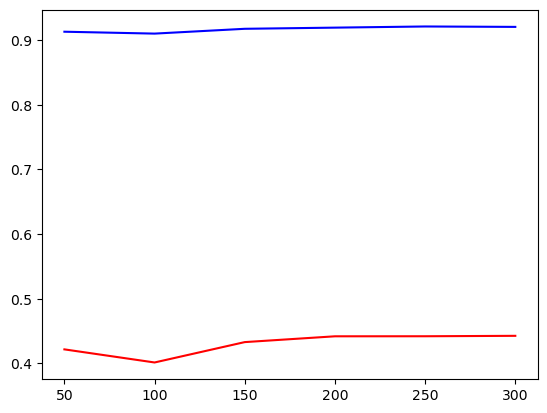

In [39]:
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV

n= [50,100,150,200,250,300,.350]
train_score, val_score= validation_curve(RandomForestRegressor(n_jobs= -1), X_train, y_train, param_name="n_estimators", param_range=n)

plt.figure()
plt.plot(n, train_score.mean(axis=1), color='blue', label="Score de validation sur le train en fonction du nombre d'arbres")
plt.plot(n, val_score.mean(axis=1), color='red', label="Score de validation sur le test en fonction du nombre d'arbres")

On constate que le score se stabilise autour de 200 itérations.

Ensuite à l'aide de GridSearchCV, on détermine la valeur de l'yperparamètre qui donne le meilleur score de validation

In [59]:
params= {'n_estimators': [50,100,150,200,250,300,400]}
grid= GridSearchCV(RandomForestRegressor(), param_grid= params, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 400]})

In [61]:
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

RandomForestRegressor(n_estimators=300)
{'n_estimators': 300}
0.44032531668607416


## DEUXIEME MODELE: GBM

In [201]:
### from sklearn.ensemble import GradientBoostingRegressor

model2= GradientBoostingRegressor(n_estimators= 3000, learning_rate= 0.2, max_depth= 10)
model2.fit(X_train, y_train)
model2.score(X_test, y_test)

0.6260757443997267

On va ensuite améliorer les performances de ce modèle sur le test.
La méthode de validation croisée par grille d'hyperparamètre étant tres couteuse, nous allons déterminer la meilleure combinaison d'hyperparamètre en testant aléatoirement k combinaisons d'hyperparamètres

In [197]:
from sklearn.model_selection import RandomizedSearchCV

params_GBM= {'n_estimators': [3000], 'learning_rate': [0.1,0.2], 'max_depth': [5,10,15]}
random_search= RandomizedSearchCV(GradientBoostingRegressor(), param_distributions= params_GBM, n_iter= 2, n_jobs= -1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=2, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2],
                                        'max_depth': [5, 10, 15],
                                        'n_estimators': [3000]})

In [199]:
random_search.best_estimator_
random_search.best_params_
random_search.best_score_

0.358860790340443

## TROISIEME MODELE: XGBOOST

In [274]:
from xgboost import XGBRegressor

model3= XGBRegressor(n_estimators= 3000, learning_rate= 0.1, max_depth= 9)
model3.fit(X_train, y_train)
model3.score(X_test, y_test)

0.630029269381512

## QUATRIEME MODELE: LE RNN

In [305]:
import torch

X= pd.read_csv("C:/Users/ccppm/OneDrive/Documents/ChallengeENSelectricité/X_train_Wwou3IE.csv")
y= pd.read_csv("C:/Users/ccppm/OneDrive/Documents/ChallengeENSelectricité/y_train_jJtXgMX.csv")

from sklearn.preprocessing import MinMaxScaler
series = y['spot_id_delta'].values

# Normalisation des données (important pour les réseaux de neurones)
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series.reshape(-1, 1))

# Créer des séquences pour les séries temporelles
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Utiliser les 30 dernières périodes pour prédire la suivante
X, y = create_sequences(series_scaled, sequence_length)

# Convertir en format PyTorch (torch.Tensor)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Diviser en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)  # 80% pour l'entraînement
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
**Archictecture du modèle**

In [ ]:
class RNN(nn.module):
    def __init__(self):
        super().__init__()
        

In [282]:
type(data)

pandas.core.series.Series

In [291]:
y_train

tensor([[0.6922],
        [0.6875],
        [0.6853],
        ...,
        [0.7041],
        [0.7045],
        [0.7091]])

In [293]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Passer par la couche RNN
        out, _ = self.rnn(x)
        # Prendre la sortie de la dernière étape temporelle
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Initialiser le modèle
model = RNNModel(input_size=1, hidden_size=50, output_size=1)

# Afficher le modèle
print(model)


RNNModel(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [295]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Hyperparamètres
learning_rate = 0.001
epochs = 50
batch_size = 32

# Fonction de perte et optimiseur
criterion = nn.MSELoss()  # Perte pour la régression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Fonction d'entraînement
for epoch in range(epochs):
    model.train()  # Mode entraînement
    for i in range(0, len(X_train), batch_size):
        # Créer les lots
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        
        # Mise à jour des gradients
        optimizer.zero_grad()
        
        # Passer les données dans le modèle
        outputs = model(X_batch)
        
        # Calculer la perte
        loss = criterion(outputs, y_batch)
        
        # Rétropropagation
        loss.backward()
        
        # Mise à jour des poids
        optimizer.step()

    # Afficher la perte chaque 10 époques
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/50, Loss: 0.0001
Epoch 20/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0001
Epoch 40/50, Loss: 0.0000
Epoch 50/50, Loss: 0.0000


Mean Squared Error: 197.0421


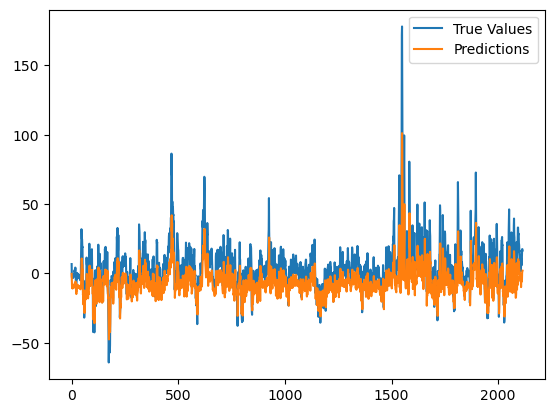

In [297]:
# Passer en mode évaluation
model.eval()

# Faire des prédictions
with torch.no_grad():
    predictions = model(X_test)

# Inverser la normalisation pour revenir aux valeurs d'origine
predictions_rescaled = scaler.inverse_transform(predictions.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"Mean Squared Error: {mse:.4f}")

# Visualiser les résultats
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, label='True Values')
plt.plot(predictions_rescaled, label='Predictions')
plt.legend()
plt.show()
